### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
#IMPORTS
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from scipy.stats import laplace

import corner


In [2]:
filename = '../../homeworks/hw_data/hw3_data_1.npy' 
data = np.load(filename)
#print(len(data))
measurments = np.array(data[:,0])
uncertainties = np.array(data[:,1])

1) Read in hw3_data_1.npy. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

From Lecture 5: 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$


In [3]:
#Sample Mean is  sample arithmetic mean of all the measurements.
#Std_error on the sample mean is sigma_mu = \sum_{i=1}^N (1/sigma_i^2)^(-1/2

sample_mean= np.sum(measurments/uncertainties**2)/np.sum(1/uncertainties**2)
std_error_mean = 1/np.sqrt(np.sum(1/(uncertainties**2)))

print('The sample mean is : {:.2f}'.format(sample_mean))
print('The standard error of the sample mean is : {:.2f}'.format(std_error_mean))


The sample mean is : 3.92
The standard error of the sample mean is : 0.09


2) Reusing some approaches and tools from Lecture_6, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. Remember that scipy optimizers are set up to minimize functions.

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [4]:
#Function calculating ln likelihood function for heteroscedastic Gaussian 
#Using scipy.optimize to find best fit mean 

def lnL_func(mu,x,sigma):
    mu_hat = np.sum((x-mu)/2*sigma)**2
    return mu_hat

f_lnL = lambda mu : lnL_func(mu,x=measurments, sigma=uncertainties)

mu_guess = 2.0
mu_fit = optimize.fmin(f_lnL, mu_guess)
print('')
print('Best-fit mean : {:.2f}'.format(mu_fit[0]))


Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 18
         Function evaluations: 36

Best-fit mean : 3.95


3) Using the same numerical technique from Lecture_5, compute the Fisher uncertainty estimate on the mean.

$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$

since, again, $\sigma = {\rm constant}$.  

Then 

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

A -  do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`,

B - divide through by our $\Delta \theta^2$ to get the correct normalization, 

C -  multiply by $-1$, 

D - then take the square root.

In [5]:
#proposed mu
mu_grid = np.linspace(1,10,100)

likelihoods = np.array([])
temp = np.array([])
for ii in range(len(mu_grid)):
    mu = mu_grid[ii]
    L = norm.logpdf(measurments, mu, uncertainties)
    L = np.sum(L)
    likelihoods= np.append(likelihoods, L)
    
    #Not sure why this code does not work instead of using the logpdf
   # temp = np.array([])
   # for iii in range(len(measurments)):
    #    lkhood = lnL_func(mu_grid[ii],measurments[iii],uncertainties[iii])
     #   temp = np.append(temp, lkhood)
   # L = np.prod(temp)
   # likelihoods= np.append(likelihoods, L)


#A
sigma_mu = np.diff((likelihoods), n=2)

#B
sigma_mu /= (mu_grid[1]-mu_grid[0])**2

#C vals already positive
sigma_mu *= -1

#D
sigma_mu = 1/np.sqrt(sigma_mu)[0]
print('Fisher Matrix Error is   : ', sigma_mu)



Fisher Matrix Error is   :  0.09481084100511059


4) Using the bootstrap method, generate  1000  bootstrap realizations of this dataset. DO NOT use the astroML code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.

100


(array([0.09799369, 0.09799369, 0.27764877, 0.37564246, 0.29398106,
        0.29398106, 0.11432597, 0.03266456, 0.01633228, 0.03266456]),
 array([1.35147524, 1.9637596 , 2.57604395, 3.1883283 , 3.80061265,
        4.41289701, 5.02518136, 5.63746571, 6.24975006, 6.86203442,
        7.47431877]),
 <BarContainer object of 10 artists>)

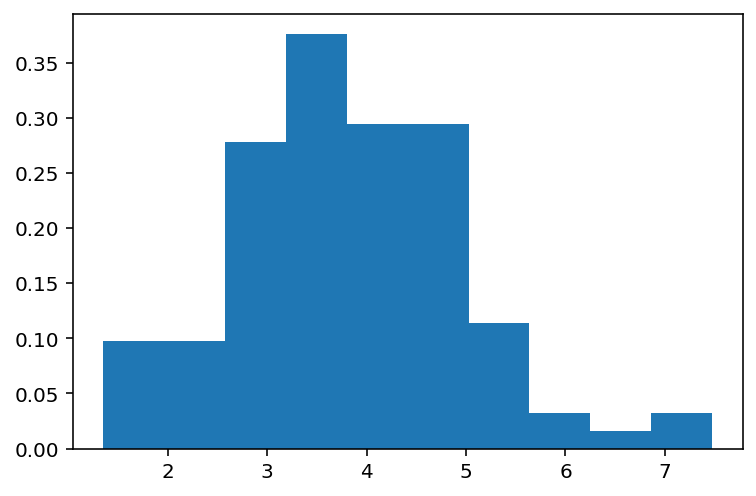

In [6]:
bootstraps = 1000
resample = 100 

#creates fake data/bootstraps data 

def bootstrap1(mu_data,sigma_data):
    samples=np.zeros(shape=(bootstraps,resample,2))
    for i in range(bootstraps):
        all_data=np.arange(resample) 
        replace_ind=np.random.randint(100,size=100)
        sample_measurment = mu_data[replace_ind]
        sample_uncenrt = sigma_data[replace_ind]
        samples[i,:,0]=sample_measurment
        samples[i,:,1]=sample_uncenrt
    return samples


#1000 arrays of fake measurments and uncertainties
realizations = bootstrap1(measurments,uncertainties) 
print(len(realizations[0]))
plt.hist(realizations[0][:,0],density=True)





5) Repeat (2) with all  1000  boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

In [7]:
bootstrap_dts = 1000
mu_guess2= 3.0 

def lnL_func2(mu,x,sigma):
    mu_hat = np.sum((x-mu)/2*sigma)**2
    return mu_hat


mu_op_boot_array = np.array([])
for j in range(bootstrap_dts):
    f_lnL_2 = lambda mu2 : lnL_func2(mu2, x=realizations[j,:,0], sigma=realizations[j,:,1])
    mu_op_boot = optimize.fmin(f_lnL_2, mu_guess2, disp= False)[0]# , args=(realizations[0][:,0][j], realizations[0][:,1][j]))
    mu_op_boot_array = np.append(mu_op_boot_array,mu_op_boot)
    
#print((mu_op_boot_array)) #100



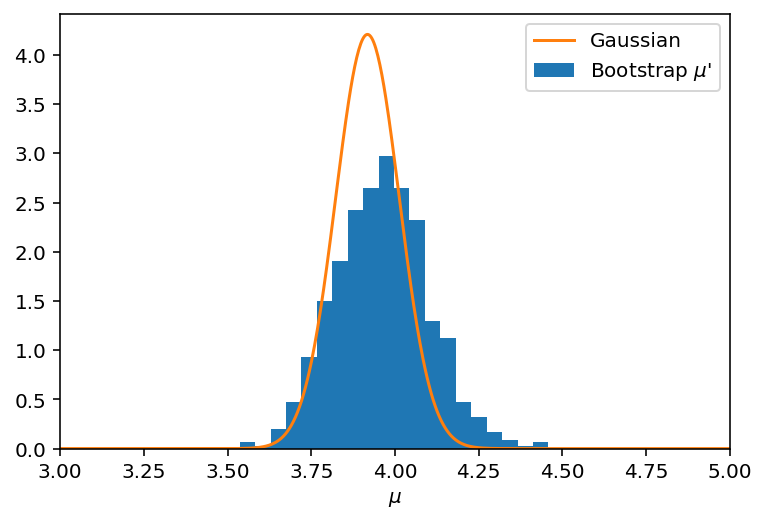

In [8]:
#From 1 
sample_mean= np.sum(measurments/uncertainties**2)/np.sum(1/uncertainties**2)
std_error_mean = 1/np.sqrt(np.sum(1/(uncertainties**2)))

distG = stats.norm(sample_mean,std_error_mean)
xgrid_G = np.linspace(2,5, 1000)
distG_pdf = distG.pdf(xgrid_G)


plt.hist(mu_op_boot_array, bins = 20, density=True, label=r"Bootstrap $\mu$'")
plt.plot(xgrid_G,distG_pdf, label = 'Gaussian')
plt.xlim([3,5])

plt.xlabel('$\mu$')
plt.legend(loc='upper right')

In [9]:
print('The histogram and gaussian agree. However the bootstrap method seems to be lower than the gaussian')



The histogram and gaussian agree. However the bootstrap method seems to be lower than the gaussian


6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter  𝜇  and scale parameter  Δ .

$$ Laplace = \frac{1}{2\Delta} \exp{(-|x-\mu|/\Delta)}$$

In [10]:
#Laplace PDF  = 1/2(delta) exp(-|x-mu|/delta) 


def laplacian(x, mu, delta):
    pdf = 1 / (2*delta) * np.exp(-(np.absolute(x - mu)) / delta)    
    return -np.log(np.prod(pdf))

likelihood_lap =  lambda beta : laplacian(x= measurments, mu=beta[0], delta=beta[1])

beta_guess= [2,2]

opt_lk_lap = optimize.fmin(likelihood_lap, beta_guess)

print('')
print('')
print('The likelihood for mu is: ' , opt_lk_lap[0], ' and delta : ', opt_lk_lap[1] )



Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 58
         Function evaluations: 112


The likelihood for mu is:  4.087802636479353  and delta :  0.8822692336474294


7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

**Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

$$L^0(M) max likelihood$$
$$k # parameters $$
$$N number data $$

In [11]:
xgrid = np.linspace(0,10,100)

#Distributions
distG2 = stats.norm(sample_mean, std_error_mean)
laplace_dist = stats.laplace(opt_lk_lap[0],opt_lk_lap[1])

#Prob Density
distG_pdf = distG2.pdf(xgrid)
laplace_pdf = laplace_dist.pdf(xgrid)

sorted_indices_G = np.argsort(distG_pdf)
sorted_indices_L = np.argsort(laplace_pdf)
index_max_G = sorted_indices_G[-1]
index_max_L = sorted_indices_L[-1]

max_Gauss = distG_pdf[index_max_G]
max_Lap = laplace_pdf[index_max_L]

In [12]:
def AIC(L_0, k, N):
    AIC = -2 *np.log(L_0) + 2 *k + (2*k*(k+1))/(N-k-1)
    return AIC

aic_gauss = AIC(max_Gauss, 1, 100)
aic_lap = AIC(max_Lap, 2, 100)

print('The AIC value for a Gaussian is : ', aic_gauss)
print('The AIC value for a Laplacian is. : ' , aic_lap)
print('The Gaussian is model is favored to the data')

The AIC value for a Gaussian is :  -0.7820944056910353
The AIC value for a Laplacian is. :  5.366936680462647
The Gaussian is model is favored to the data


8) Using the  1000  bootstrap datasets from before, fit for the Laplacian  𝜇  and  Δ  for each. Make a nice corner plot of the distributions of  𝜇  and  Δ  that shows both the marginal  1 D distributions and the joint  2 D distribution. Make sure the plot has labels, shows the titles on each  1 D marginal panel, and has  68%  and  95%  levels.


In [13]:
#Not sure if it got disintsalled in my enviroment but I was not able to import it at first 
!pip install corner 

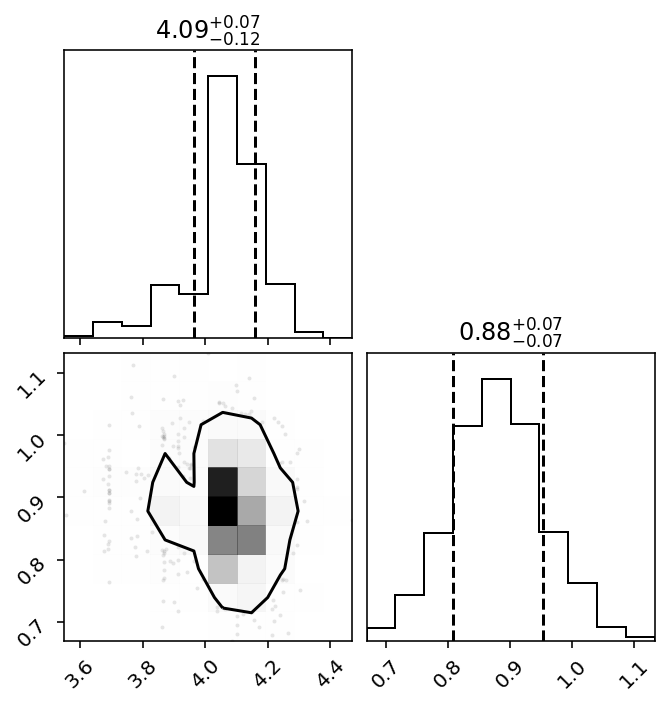

In [14]:
import corner 

lap_x = np.array([])
lap_delta = np.array([])

for jj in range((1000)): 
    lap_lkh = lambda beta3 : laplacian(x = realizations[jj,:,0], mu = beta3[0], delta = beta3[1])
    lap_guess = [3,1]
    max_lk_lap = optimize.fmin(lap_lkh, lap_guess, disp=False)
    
    lap_x = np.append(lap_x, max_lk_lap[0])
    lap_delta = np.append(lap_delta, max_lk_lap[1])


laplacian_array = np.ones(shape =(1000,2))
laplacian_array[:,0] = lap_x
laplacian_array[:,1] = lap_delta

#len(laplacian_array[0])
fig = corner.corner(laplacian_array, bins =10, quantiles=(0.16, 0.84),
                    levels=(0.16,0.84), label = ['$\mu$', '$\Delta$'],
                    show_titles=True)

    
    
    

In [15]:
print('Lapalacain values seem to match to the likelihood for mu  (4.08 vs 4.09  and)  and  delta (0.88 vs 0.79)')

print('However, the delta plot looks very binomail so I am not super sure if it is correct')
print('')
print('Nevermind, I chose different guesses (3,1) and now the laplacian values and likelihood match now, before I had [0,1] and the delta distribution looked binomial-ish ')



Lapalacain values seem to match to the likelihood for mu  (4.08 vs 4.09  and)  and  delta (0.88 vs 0.79)
However, the delta plot looks very binomail so I am not super sure if it is correct

Nevermind, I chose different guesses (3,1) and now the laplacian values and likelihood match now, before I had [0,1] and the delta distribution looked binomial-ish 


9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install numdifftools which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters  𝜇  and  Δ . To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on  𝜇  and  Δ . How does these compare to the bootstrap distribution widths found in (8)?

In [18]:
import numdifftools as nd

H = nd.Hessian(lap_lkh)([max_lk_lap[0], max_lk_lap[1]])
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)
print('Mu Uncertainties :  0.095 vs  0.10') #higher val fisher

std_delta = np.std(laplacian_array[:,1])
print('Delta Uncertainties :' ,std_delta, ' vs 0.08' ) #higher val fisher 

print('the diagonals match with the mu and delta found before')

[[0.10153728        nan]
 [       nan 0.08217837]]
Mu Uncertainties :  0.095 vs  0.10
Delta Uncertainties : 0.07404859076127478  vs 0.08
the diagonals match with the mu and delta found before


/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/numdifftools/core.py:899: RuntimeWarning: invalid value encountered in double_scalars
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [17]:
!pip install numdifftools